In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
%cd /content/drive/MyDrive/Github/ml-blog

/content/drive/MyDrive/Github/ml-blog


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

## Import Scaled Data

In [3]:
filename = 'taiwan-credit-col-transform-FULL.csv'

In [4]:
DATA = os.path.relpath('/content/drive/MyDrive/Github/ml-blog/credit/data/' + filename)

df = pd.read_csv(DATA, index_col='ID', header=0)
df.head()

,category__SEX_1,category__SEX_2,category__EDUCATION_0,category__EDUCATION_1,category__EDUCATION_2,category__EDUCATION_3,category__EDUCATION_4,category__EDUCATION_5,category__EDUCATION_6,category__MARRIAGE_0,...,nums__BILL_AMT4,nums__BILL_AMT5,nums__BILL_AMT6,nums__PAY_AMT1,nums__PAY_AMT2,nums__PAY_AMT3,nums__PAY_AMT4,nums__PAY_AMT5,nums__PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382,1
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878,1
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.449730,-0.417188,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122,0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.232373,-0.186729,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130,0
5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.346997,-0.348137,-0.331482,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187,0


In [5]:
X = df.iloc[:, :91]
y = df.iloc[:, 91]
X.columns, y.name, y.shape

(Index(['category__SEX_1', 'category__SEX_2', 'category__EDUCATION_0',
        'category__EDUCATION_1', 'category__EDUCATION_2',
        'category__EDUCATION_3', 'category__EDUCATION_4',
        'category__EDUCATION_5', 'category__EDUCATION_6',
        'category__MARRIAGE_0', 'category__MARRIAGE_1', 'category__MARRIAGE_2',
        'category__MARRIAGE_3', 'category__PAY_0_-2', 'category__PAY_0_-1',
        'category__PAY_0_0', 'category__PAY_0_1', 'category__PAY_0_2',
        'category__PAY_0_3', 'category__PAY_0_4', 'category__PAY_0_5',
        'category__PAY_0_6', 'category__PAY_0_7', 'category__PAY_0_8',
        'category__PAY_2_-2', 'category__PAY_2_-1', 'category__PAY_2_0',
        'category__PAY_2_1', 'category__PAY_2_2', 'category__PAY_2_3',
        'category__PAY_2_4', 'category__PAY_2_5', 'category__PAY_2_6',
        'category__PAY_2_7', 'category__PAY_2_8', 'category__PAY_3_-2',
        'category__PAY_3_-1', 'category__PAY_3_0', 'category__PAY_3_1',
        'category__PAY_3_2'

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic Regression Baseline

In [7]:
lr_base_clf = LogisticRegression(penalty='l2', tol=0.0001, 
                             C=1, solver='lbfgs', 
                             max_iter=500, multi_class='ovr').fit(X_train, y_train)

In [8]:
y_lrbase_preds = lr_base_clf.predict(X_test)

In [9]:
print(confusion_matrix(y_test, y_lrbase_preds))

[[4461  226]
 [ 861  452]]


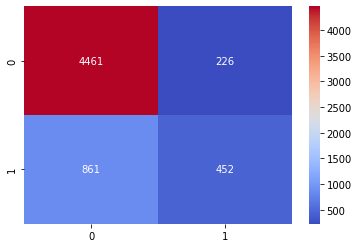

In [10]:
sns.heatmap(confusion_matrix(y_test, y_lrbase_preds), cmap='coolwarm', annot=True, fmt='g')

In [11]:
print(classification_report(y_test, y_lrbase_preds))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4687
           1       0.67      0.34      0.45      1313

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.67      6000
weighted avg       0.80      0.82      0.80      6000



It's about what we expected....


## GridSearchCV to compare hyperparameter settings

In [12]:
lr_param_grid = [
    {'penalty': ['l2'], 'C': [0.1, 1.0, 5.0, 10.0, 100.0], 'tol': [0.001, 0.01, 0.5, 1.0]},
    {'penalty': ['l1'], 'C': [0.1, 1.0, 5.0, 10.0, 100.0], 'tol': [0.001, 0.01, 0.5, 1.0]},
    {'penalty': ['none'], 'tol': [0.001, 0.01, 0.5, 1.0]},
]

xgb_param_grid = [
    {'max_depth': [2], 'n_estimators': [25, 50, 100, 500], 'learning_rate': [0.01, 0.05, 0.075, 0.1]},
    {'max_depth': [4], 'n_estimators': [25, 50, 100, 500], 'learning_rate': [0.01, 0.05, 0.075, 0.1]},
    {'max_depth': [6], 'n_estimators': [25, 50, 100, 500], 'learning_rate': [0.01, 0.05, 0.075, 0.1]},
]

lr = LogisticRegression(max_iter=2000, solver='saga')

xgb = XGBClassifier(use_label_encoder=False)


In [13]:
lr_clf = GridSearchCV(lr, param_grid=lr_param_grid, scoring='roc_auc')
lr_clf.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=2000, solver='saga'),
             param_grid=[{'C': [0.1, 1.0, 5.0, 10.0, 100.0], 'penalty': ['l2'],
                          'tol': [0.001, 0.01, 0.5, 1.0]},
                         {'C': [0.1, 1.0, 5.0, 10.0, 100.0], 'penalty': ['l1'],
                          'tol': [0.001, 0.01, 0.5, 1.0]},
                         {'penalty': ['none'], 'tol': [0.001, 0.01, 0.5, 1.0]}],
             scoring='roc_auc')

In [14]:
print(lr_clf.best_params_, lr_clf.best_estimator_, round(lr_clf.best_score_, 3))

{'C': 0.1, 'penalty': 'l2', 'tol': 0.001} LogisticRegression(C=0.1, max_iter=2000, solver='saga', tol=0.001) 0.768


In [15]:
xgb_clf = GridSearchCV(xgb, param_grid=xgb_param_grid, scoring='roc_auc')
xgb_clf.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(use_label_encoder=False),
             param_grid=[{'learning_rate': [0.01, 0.05, 0.075, 0.1],
                          'max_depth': [2],
                          'n_estimators': [25, 50, 100, 500]},
                         {'learning_rate': [0.01, 0.05, 0.075, 0.1],
                          'max_depth': [4],
                          'n_estimators': [25, 50, 100, 500]},
                         {'learning_rate': [0.01, 0.05, 0.075, 0.1],
                          'max_depth': [6],
                          'n_estimators': [25, 50, 100, 500]}],
             scoring='roc_auc')

In [16]:
print(xgb_clf.best_params_, xgb_clf.best_estimator_, round(xgb_clf.best_score_, 3))

{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100} XGBClassifier(learning_rate=0.05, max_depth=6, use_label_encoder=False) 0.783


## Evaluation, Graphs, etc.

In [17]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [18]:
y_lr_probas = lr_clf.predict_proba(X_test)[:, 1] # using the 'greater label', i.e., 0 for 'No default'.

In [19]:
y_xgb_probas = xgb_clf.predict_proba(X_test)[:, 1]

In [20]:
y_xgb_probas.shape

(6000,)

In [21]:
y_test_np = y_test.to_numpy()

In [22]:
y_test_np.shape

(6000,)

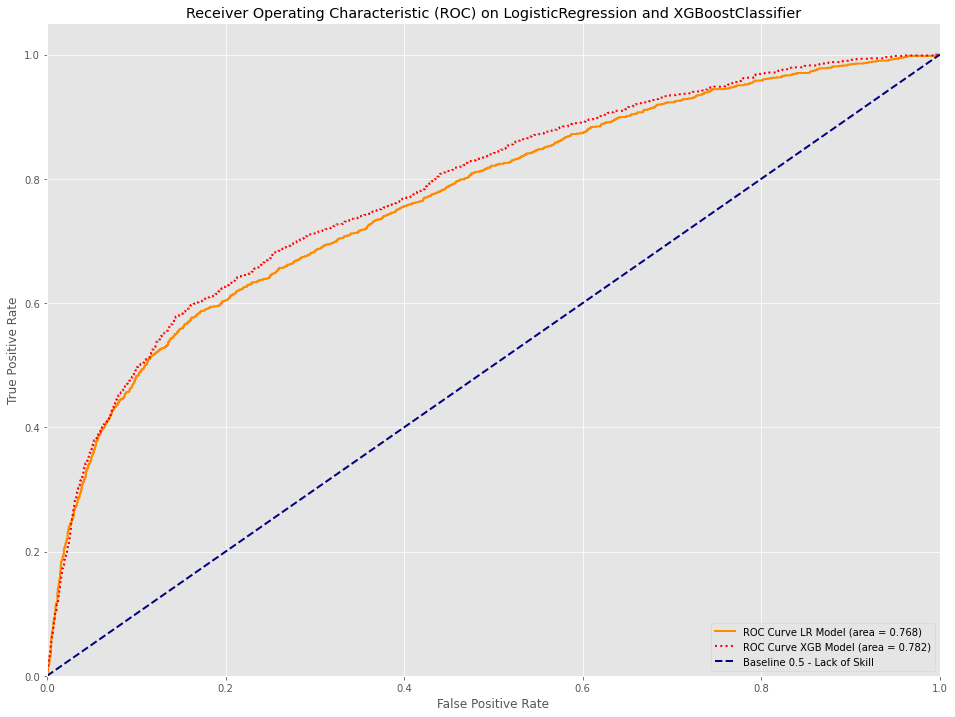

In [26]:
truePR_lr = dict()
falsePR_lr = dict()
roc_auc_lr = dict()

truePR_xgb = dict()
falsePR_xgb = dict()
roc_auc_xgb = dict()


falsePR_lr, truePR_lr, _ = roc_curve(y_test_np, y_lr_probas)
roc_auc_lr = auc(falsePR_lr, truePR_lr)

falsePR_xgb, truePR_xgb, _ = roc_curve(y_test_np, y_xgb_probas)
roc_auc_xgb = auc(falsePR_xgb, truePR_xgb)


plt.style.use('ggplot')
plt.figure(figsize=(16,12))
lw = 2

plt.plot(
    falsePR_lr,
    truePR_lr,
    color='darkorange',
    lw=lw,
    label="ROC Curve LR Model (area = %0.3f)" % roc_auc_lr,
)

plt.plot(
    falsePR_xgb,
    truePR_xgb,
    color='red',
    linestyle='dotted',
    lw=lw,
    label="ROC Curve XGB Model (area = %0.3f)" % roc_auc_xgb,
)

plt.plot([0,1], color='navy', lw=lw, linestyle='--', label='Baseline 0.5 - Lack of Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) on LogisticRegression and XGBoostClassifier')
plt.legend(loc='lower right')
plt.savefig('./credit/model/best-combo-model-auc.png')
plt.show()

In [ ]:
y_xgb_probas = xgb_clf.predict_proba(X_test)[:, 1] # using the 'greater label', i.e., 0 for 'No default'.

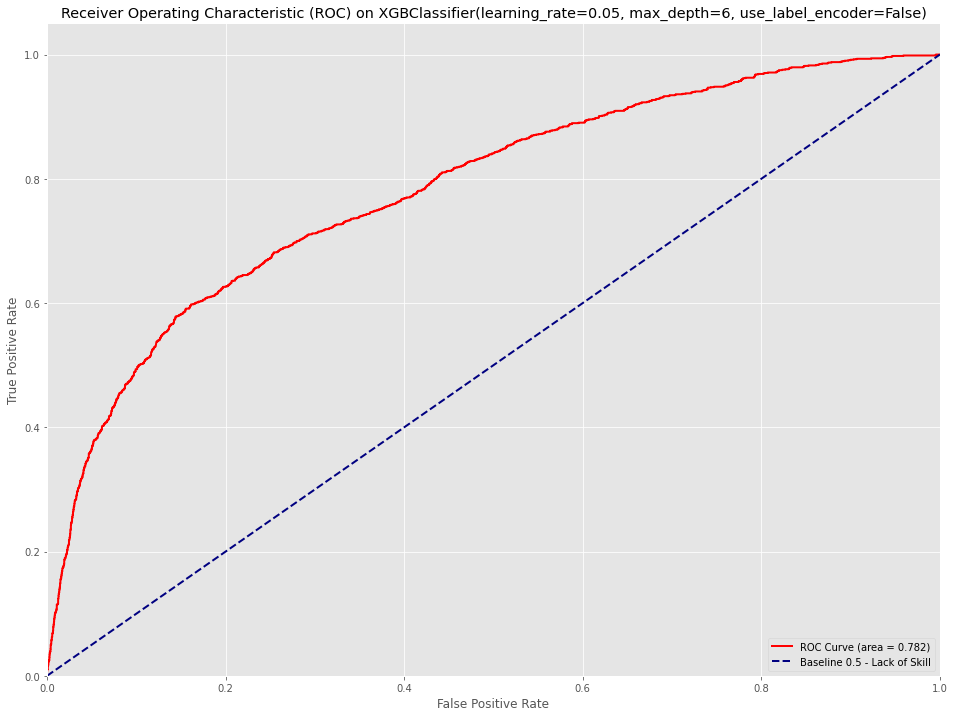

In [28]:
truePR = dict()
falsePR = dict()
roc_auc = dict()


falsePR, truePR, _ = roc_curve(y_test_np, y_xgb_probas)
roc_auc = auc(falsePR, truePR)

plt.style.use('ggplot')
plt.figure(figsize=(16,12))
lw = 2
plt.plot(
    falsePR,
    truePR,
    color='red',
    lw=lw,
    label="ROC Curve (area = %0.3f)" % roc_auc,
)

plt.plot([0,1], color='navy', lw=lw, linestyle='--', label='Baseline 0.5 - Lack of Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) on XGBClassifier(learning_rate=0.05, max_depth=6, use_label_encoder=False)')
plt.legend(loc='lower right')
plt.savefig('./credit/model/best-xgb-model-auc.png')
plt.show()

In [29]:
y_lr_preds = lr_clf.predict(X_test)
y_xgb_preds = xgb_clf.predict(X_test)

In [30]:
print(classification_report(y_test_np, y_lr_preds))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4687
           1       0.66      0.35      0.46      1313

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.67      6000
weighted avg       0.80      0.82      0.80      6000



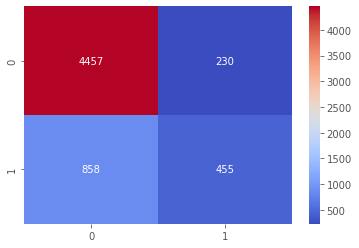

In [31]:
sns.heatmap(confusion_matrix(y_test, y_lr_preds), cmap='coolwarm', annot=True, fmt='g')

In [32]:
print(classification_report(y_test_np, y_xgb_preds))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4687
           1       0.68      0.35      0.47      1313

    accuracy                           0.82      6000
   macro avg       0.76      0.65      0.68      6000
weighted avg       0.81      0.82      0.80      6000



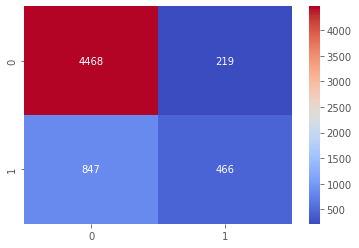

In [33]:
sns.heatmap(confusion_matrix(y_test, y_xgb_preds), cmap='coolwarm', annot=True, fmt='g')

## SMOTE to Address Class Imbalance

* The dataset has a clear imbalance in the label counts. This means our models will have trouble discerning a **minority class** instance clearly.
* We can use the **SMOTE** method to improve class balance.

In [34]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [35]:
ov = SMOTE(sampling_strategy=0.5, random_state=42)
und = RandomUnderSampler(sampling_strategy=0.35, random_state=42)

In [36]:
from collections import Counter

In [37]:
count = Counter(y)
print(count, 'Ratio: ', round(count[1]/count[0], 4), '% minority class (1)')

Counter({0: 23364, 1: 6636}) Ratio:  0.284 % minority class (1)


In [38]:
count_train = Counter(y_train)
print(count_train, 'Ratio: ', round(count_train[1]/count_train[0], 4), '% minority class (1)')

Counter({0: 18677, 1: 5323}) Ratio:  0.285 % minority class (1)


In [39]:
test_pipe = Pipeline(steps=([('und', und), ('ov', ov)]))

In [40]:
X_res, y_res = test_pipe.fit_resample(X_train, y_train)

In [41]:
count_res = Counter(y_res)
print(count_res, 'Ratio: ', round(count_res[1]/count_res[0], 4), '% minority class (1)')

Counter({0: 15208, 1: 7604}) Ratio:  0.5 % minority class (1)


In [42]:
# {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100} XGBClassifier(learning_rate=0.05, max_depth=6, use_label_encoder=False) 0.783
xgb = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.05, use_label_encoder=False)
over = SMOTE(sampling_strategy=0.5, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.35, random_state=42)

steps = [('under', under), ('over', over), ('xgb_clf', xgb)]
smote_model = Pipeline(steps=steps)

In [43]:
smote_model.fit(X_train, y_train)

Pipeline(steps=[('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.35)),
                ('over', SMOTE(random_state=42, sampling_strategy=0.5)),
                ('xgb_clf',
                 XGBClassifier(learning_rate=0.05, max_depth=6,
                               use_label_encoder=False))])

In [44]:
y_smote_probas = smote_model.predict_proba(X_test)[:, 1] # using the 'greater label', i.e., 0 for 'No default'.

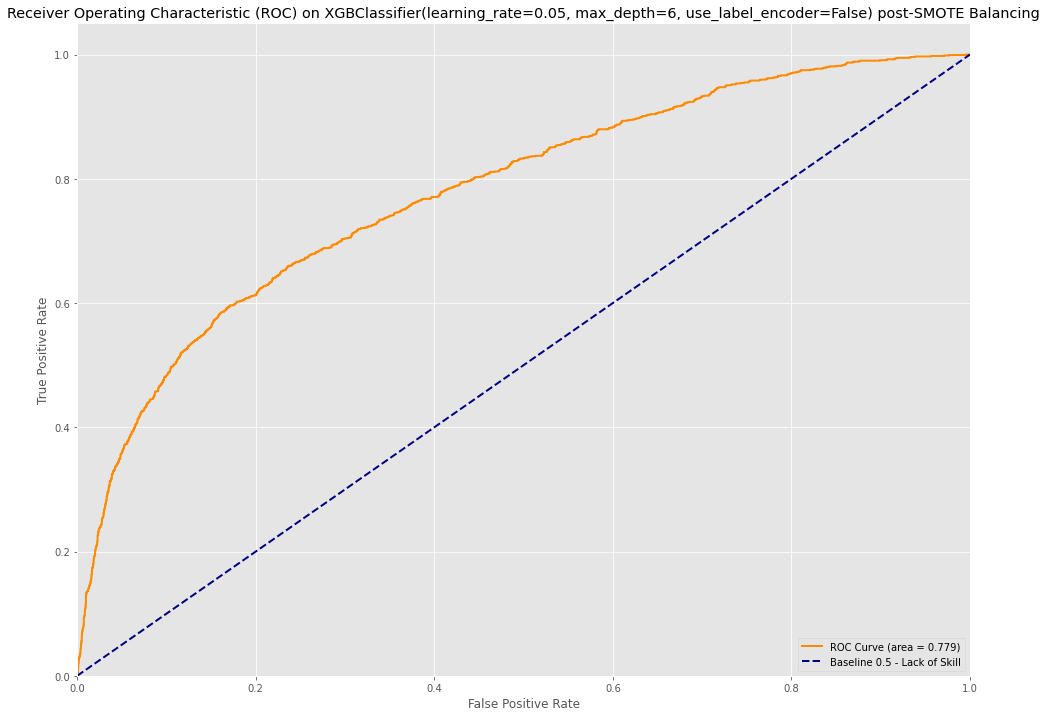

In [55]:
truePR = dict()
falsePR = dict()
roc_auc = dict()


falsePR, truePR, _ = roc_curve(y_test, y_smote_probas)
roc_auc = auc(falsePR, truePR)

plt.style.use('ggplot')
plt.figure(figsize=(16,12))
lw = 2
plt.plot(
    falsePR,
    truePR,
    color='darkorange',
    lw=lw,
    label="ROC Curve (area = %0.3f)" % roc_auc,
)

plt.plot([0,1], color='navy', lw=lw, linestyle='--', label='Baseline 0.5 - Lack of Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) on XGBClassifier(learning_rate=0.05, max_depth=6, use_label_encoder=False) post-SMOTE Balancing')
plt.legend(loc='lower right')
plt.savefig('./credit/model/best-xgb-model-auc-smote.png')
plt.show()

In [46]:
y_smote_preds = smote_model.predict(X_test)

In [47]:
print(classification_report(y_test, y_smote_preds))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      4687
           1       0.63      0.42      0.50      1313

    accuracy                           0.82      6000
   macro avg       0.74      0.67      0.69      6000
weighted avg       0.80      0.82      0.80      6000



* The **precision** of **class 0** : $0.85$
* The **recall** (sensitivity) of class 0 : $0.93$
* The **false discovery rate** of class 0 : $1 - 0.85 = 0.15$


* The **precision** of **class 1**, the **minority class** : $0.63$
* The **recall** of class 1 : $0.42$
* The **false discovery rate** of class 1 : $1 - 0.63 = 0.37$


* The **False Negative Rate** of **Class 1** is $1 - recall$, or **$1 - 0.42 = 0.58$**
This is **the rate of missing credit defaults**.

In [48]:
from imblearn.under_sampling import NeighbourhoodCleaningRule

In [49]:
# {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100} XGBClassifier(learning_rate=0.05, max_depth=6, use_label_encoder=False) 0.783
xgb = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.05, use_label_encoder=False)
over = SMOTE(sampling_strategy=0.5, random_state=42)
under = NeighbourhoodCleaningRule(sampling_strategy='auto', n_neighbors=3, n_jobs=1)

steps = [('under', under), ('over', over), ('xgb_clf', xgb)]
ncr_model = Pipeline(steps=steps)

In [50]:
ncr_model.fit(X_train, y_train)

Pipeline(steps=[('under', NeighbourhoodCleaningRule(n_jobs=1)),
                ('over', SMOTE(random_state=42, sampling_strategy=0.5)),
                ('xgb_clf',
                 XGBClassifier(learning_rate=0.05, max_depth=6,
                               use_label_encoder=False))])

In [51]:
y_ncr_probas = ncr_model.predict_proba(X_test)[:, 1] # using the 'greater label', i.e., 0 for 'No default'.

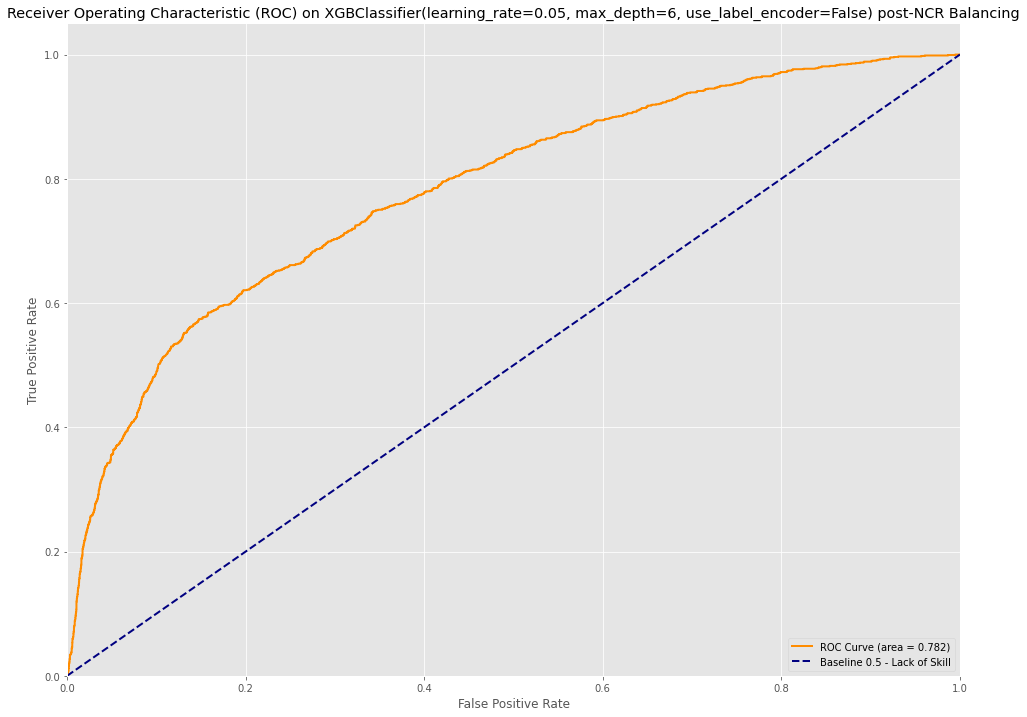

In [56]:
truePR = dict()
falsePR = dict()
roc_auc = dict()


falsePR, truePR, _ = roc_curve(y_test, y_ncr_probas)
roc_auc = auc(falsePR, truePR)

plt.style.use('ggplot')
plt.figure(figsize=(16,12))
lw = 2
plt.plot(
    falsePR,
    truePR,
    color='darkorange',
    lw=lw,
    label="ROC Curve (area = %0.3f)" % roc_auc,
)

plt.plot([0,1], color='navy', lw=lw, linestyle='--', label='Baseline 0.5 - Lack of Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) on XGBClassifier(learning_rate=0.05, max_depth=6, use_label_encoder=False) post-NCR Balancing')
plt.legend(loc='lower right')
plt.savefig('./credit/model/best-xgb-model-auc-ncr.png')
plt.show()

In [53]:
y_ncr_preds = ncr_model.predict(X_test)

In [54]:
print(classification_report(y_test, y_ncr_preds))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      4687
           1       0.53      0.57      0.55      1313

    accuracy                           0.79      6000
   macro avg       0.70      0.71      0.71      6000
weighted avg       0.80      0.79      0.80      6000



* The **precision** of **class 0** : 0.88;
* The **recall** (sensitivity) of class 0 : 0.86
* The **false discovery rate** of class 0 : $1 - 0.88 = 0.12$


* The **precision** of **class 1**, the **minority class** : 0.53
* The **recall** of class 1 : 0.57
* The **false discovery rate** of class 1 : $1 - 0.53 = 0.47$